# Jupyter notebook for debugging

In [1]:
%load_ext autoreload
%autoreload 2

# Copied from `train` function in train_simple.py:L78
import yaml

device = 'cpu'
hyp = 'data/hyps/hyp.scratch-low.yaml'

with open(hyp, errors="ignore") as f:
    hyp = yaml.safe_load(f)  # load hyps dict

In [2]:
from models.yolo import Model
from utils.general import check_dataset

cfg = 'models/yolov5n_kaist-rgbt.yaml'
data = 'data/kaist-rgbt.yaml'
data_dict = check_dataset(data)

nc = int(data_dict["nc"])  # number of classes
model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)  # create

Overriding model.yaml nc=1 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.MultiStreamConv           [3, 16, 6, 2, 2]              
  1                -1  1      9344  models.common.MultiStreamConv           [16, 32, 3, 2]                
  2                -1  1      9600  models.common.MultiStreamC3             [32, 32, 1]                   
  3                -1  1         0  models.common.Fusion                    ['concat', 2]                 
  4                -1  1      4224  models.common.Conv                      [64, 64, 1, 1]                
  5                -1  1     36992  models.common.Conv                      [64, 64, 3, 2]                
  6                -1  2     29184  models.common.C3                        [64, 64, 2]                   
  7                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               

In [3]:
anchors = model.model[-1].anchors

# [TODO] Draw anchors
# 첫 번째 TODO: 앵커 그리기
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from utils.general import xywhn2xyxy
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import cv2

# anchors 형태 및 stride 확인
print("Anchors shape:", anchors.shape)
print("Anchors:", anchors)
print("Model stride:", model.stride)

# 수정된 앵커 시각화 함수
def draw_anchors(anchors, img_size=640, grid_size=None):
    """
    앵커 박스를 시각화합니다.
    anchors: 앵커 텐서
    img_size: 모델 입력 이미지 크기
    grid_size: 그리드 크기 (stride로 계산)
    """
    if grid_size is None:
        grid_size = max(int(model.stride.max()), 32)
    
    # 빈 정사각형 이미지 생성
    img = np.zeros((img_size, img_size, 3), dtype=np.uint8)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    
    # 모델의 stride 가져오기 (텐서를 numpy로 변환)
    if isinstance(model.stride, torch.Tensor):
        strides = model.stride.cpu().numpy()
    else:
        strides = np.array(model.stride)
    
    # 각 스케일 레벨에 대한 색상
    colors = ['r', 'g', 'b']
    
    # 앵커 박스 그리기
    for i, stride in enumerate(strides):
        # 앵커의 형태에 따라 인덱싱 방식 조정
        if anchors.dim() == 3:  # 형태가 (3, n_layers, 2)인 경우
            anchors_layer = anchors[:, i, :].clone().cpu()
        else:  # 형태가 (n_anchors, 2)인 경우
            anchors_layer = anchors.clone().cpu()
        
        # 그리드 중앙에 앵커 위치
        grid_center = img_size / 2
        
        for j, anchor in enumerate(anchors_layer):
            if isinstance(anchor, torch.Tensor):
                w, h = anchor.cpu().numpy() * stride
            else:
                w, h = anchor * stride
            
            # 중앙을 기준으로 앵커 위치 계산
            x1, y1 = grid_center - w/2, grid_center - h/2
            
            # 앵커 박스 그리기
            rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor=colors[j % len(colors)], facecolor='none')
            plt.gca().add_patch(rect)
            
            # 앵커 라벨 추가
            plt.text(x1, y1, f'S{i+1}A{j+1}: {w:.0f}x{h:.0f}', 
                    color=colors[j % len(colors)], fontsize=8, weight='bold')
    
    plt.title('Anchor Boxes')
    plt.axis('on')
    plt.tight_layout()
    
    # 반환 대신 저장 및 표시
    plt.savefig('anchor_boxes.png')  # 파일로 저장
    plt.show()  # 다시 표시 시도

# anchors가 텐서가 아니라면 텐서로 변환
if not isinstance(anchors, torch.Tensor):
    anchors = torch.tensor(anchors)

# 앵커 시각화 호출
draw_anchors(anchors)

# 앵커 데이터를 직접 출력해서 확인
for i in range(anchors.shape[0]):
    if anchors.dim() == 3:
        for j in range(anchors.shape[1]):
            print(f"Anchor [{i},{j}]: {anchors[i,j]}")
    else:
        print(f"Anchor [{i}]: {anchors[i]}")

Anchors shape: torch.Size([3, 3, 2])
Anchors: tensor([[[ 1.25000,  1.62500],
         [ 2.00000,  3.75000],
         [ 4.12500,  2.87500]],

        [[ 1.87500,  3.81250],
         [ 3.87500,  2.81250],
         [ 3.68750,  7.43750]],

        [[ 3.62500,  2.81250],
         [ 4.87500,  6.18750],
         [11.65625, 10.18750]]])
Model stride: tensor([ 8., 16., 32.])
Anchor [0,0]: tensor([1.25000, 1.62500])
Anchor [0,1]: tensor([2.00000, 3.75000])
Anchor [0,2]: tensor([4.12500, 2.87500])
Anchor [1,0]: tensor([1.87500, 3.81250])
Anchor [1,1]: tensor([3.87500, 2.81250])
Anchor [1,2]: tensor([3.68750, 7.43750])
Anchor [2,0]: tensor([3.62500, 2.81250])
Anchor [2,1]: tensor([4.87500, 6.18750])
Anchor [2,2]: tensor([11.65625, 10.18750])


## Sanity check: dataset
- Read images and label
- Visualize bounding boxes

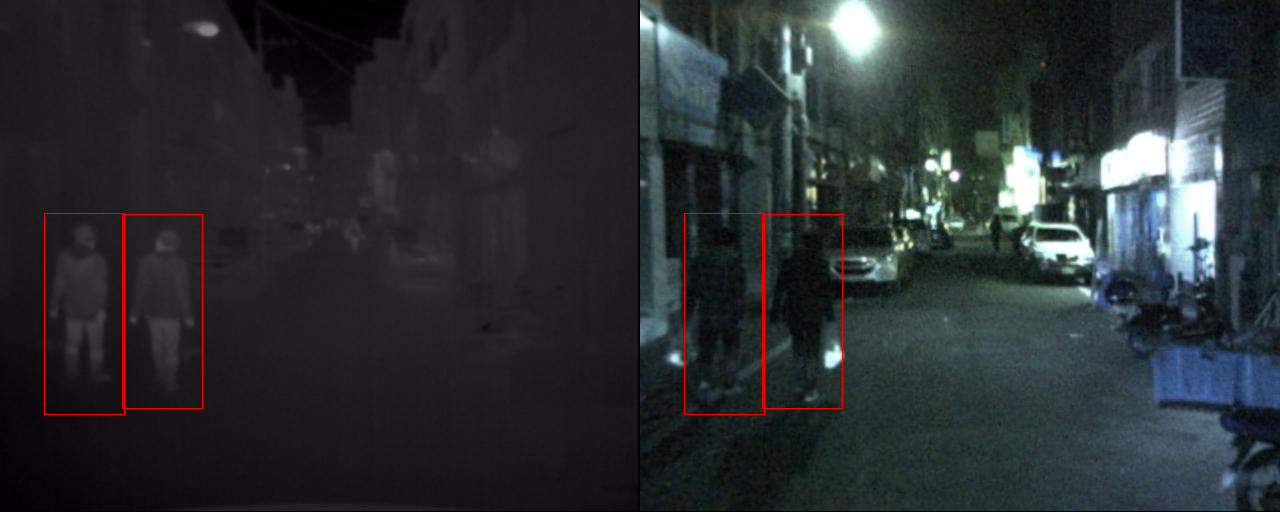

In [4]:
import cv2
import os
import numpy as np
from PIL import Image

# annFile = 'datasets/kaist-rgbt/train/labels/set05_V000_I01219.txt'
annFile = 'datasets/kaist-rgbt/train/labels/set05_V000_I00547.txt'
lwirFile = annFile.replace('labels', 'images/lwir').replace('.txt', '.jpg')
visFile  = annFile.replace('labels', 'images/visible').replace('.txt', '.jpg')

# Read images
img_lwir = cv2.imread(lwirFile)
img_vis  = cv2.imread(visFile)

h, w = img_vis.shape[:2]

# Read labels
with open(annFile, 'r') as fp:
    labels = [x.split() for x in fp.read().strip().splitlines() if len(x)]

colors = {
    0: (255, 0, 0),
    1: (0, 255, 0),
    2: (0, 0, 255),
    3: (255, 0, 255),
}

if len(labels):
    # convert normalized bbox to pixel coordinates
    labels = np.array(labels, dtype=np.float32)
    labels[:, (1, 3)] *= w
    labels[:, (2, 4)] *= h

    cls = labels[:, 0]

    xyxy = np.zeros((len(labels), 4))
    xyxy[:, :2] = labels[:, 1:3]
    xyxy[:, 2:] = labels[:, 1:3] + labels[:, 3:5]
    xyxy = xyxy.astype(np.int16)

    for c, bb in zip(cls, xyxy):
        color = colors[c]
        cv2.rectangle(img_lwir, bb[:2], bb[2:], color)
        cv2.rectangle(img_vis,  bb[:2], bb[2:], color)

images = np.concatenate([img_lwir, img_vis], axis=1)
Image.fromarray(images)

## Sanity check: dataset class
- Visualize bounding boxes from dataset class

In [5]:
from utils.dataloaders import create_dataloader
from utils.general import check_img_size, colorstr

imgsz = 640
batch_size = 1
single_cls = False
seed = 0

train_path = data_dict["train"]
gs = max(int(model.stride.max()), 32)  # grid size (max stride)
imgsz = check_img_size(imgsz, gs, floor=gs * 2)  # verify imgsz is gs-multiple

train_loader, dataset = create_dataloader(
    train_path,
    imgsz,
    batch_size,
    gs,
    single_cls,
    hyp=hyp,
    augment=False,      # TODO: check if there is no bug when applying augmentation
    cache=None,
    rect=False,
    rank=-1,
    workers=8,
    image_weights=False,
    quad=False,
    prefix=colorstr("train: "),
    shuffle=False,      # No shuffle for debugging
    seed=seed,
    rgbt_input=True,
)


train: Scanning /home/lbw/workspace/AUE8088/datasets/kaist-rgbt/train-all-04.cache... 12538 images, 7009 backgrounds, 0 corrupt: 100%|██████████| 12538/12538 [00:00<?, ?it/s]


datasets/kaist-rgbt/train/images/{}/set05_V000_I01219.jpg


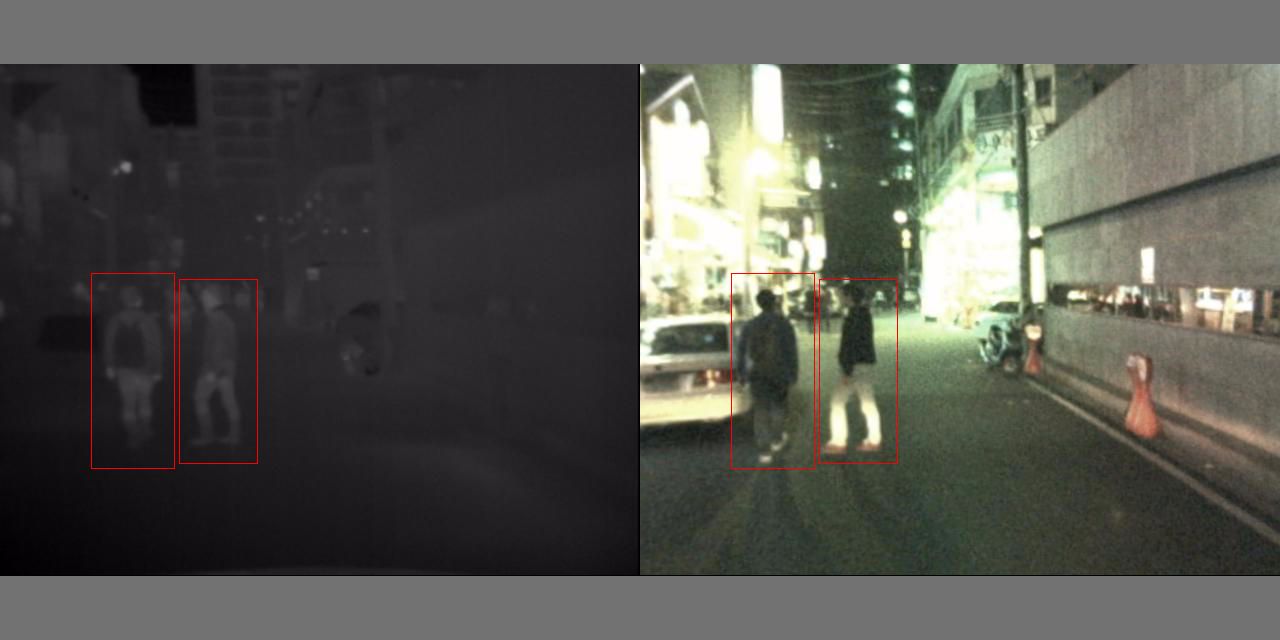

In [6]:
from utils.dataloaders import LoadRGBTImagesAndLabels
from utils.general import xywh2xyxy

frame = 12112
# frame = 12119
# frame = 12120

# Get a minibatch
# for ii, (imgs, targets, paths, _) in enumerate(train_loader):
#     break

# Get a minibatch (fast)
imgs, targets, paths, shapes, _ = LoadRGBTImagesAndLabels.collate_fn([dataset[frame]])

idx = 0
img_lwir = imgs[0][idx].numpy().transpose((1, 2, 0))
img_vis  = imgs[1][idx].numpy().transpose((1, 2, 0))
h, w = img_vis.shape[:2]

labels = targets.numpy()

colors = {
    0: (255, 0, 0),
    1: (0, 255, 0),
    2: (0, 0, 255),
    3: (255, 0, 255),
}

if len(labels):
    labels = labels[labels[:, 0] == idx, 1:]

    # convert normalized bbox to pixel coordinates
    labels = np.array(labels, dtype=np.float32)
    labels[:, (1, 3)] *= w
    labels[:, (2, 4)] *= h

    cls = labels[:, 0]

    xyxy = xywh2xyxy(labels[:, 1:5])
    xyxy = xyxy.astype(np.int16)

    img_lwir = np.ascontiguousarray(img_lwir)
    img_vis = np.ascontiguousarray(img_vis)

    for c, bb in zip(cls, xyxy):
        color = colors[c]
        cv2.rectangle(img_lwir, bb[:2], bb[2:], color)
        cv2.rectangle(img_vis,  bb[:2], bb[2:], color)

images = np.concatenate([img_lwir, img_vis], axis=1)
print(paths[idx])
Image.fromarray(images)

## Run trained model
- Visualize bounding boxes from dataset class

YOLOv5 🚀 f43ed65 Python-3.11.2 torch-2.7.0+cu126 CPU


                 from  n    params  module                                  arguments                     
  0                -1  1      7040  models.common.MultiStreamConv           [3, 32, 6, 2, 2]              
  1                -1  1     37120  models.common.MultiStreamConv           [32, 64, 3, 2]                
  2                -1  1    132608  models.common.MultiStreamC3             [64, 128, 1]                  
  3                -1  1         0  models.common.Fusion                    ['concat', 2]                 
  4                -1  1    295168  models.common.Conv                      [256, 128, 3, 2]              
  5                -1  1    198144  models.common.C3k2                      [128, 256, False]             
  6                -1  1    590336  models.common.Conv                      [256, 256, 3, 2]              
  7                -1  1    919808  models.common.C3k2                      [256, 256, Tr

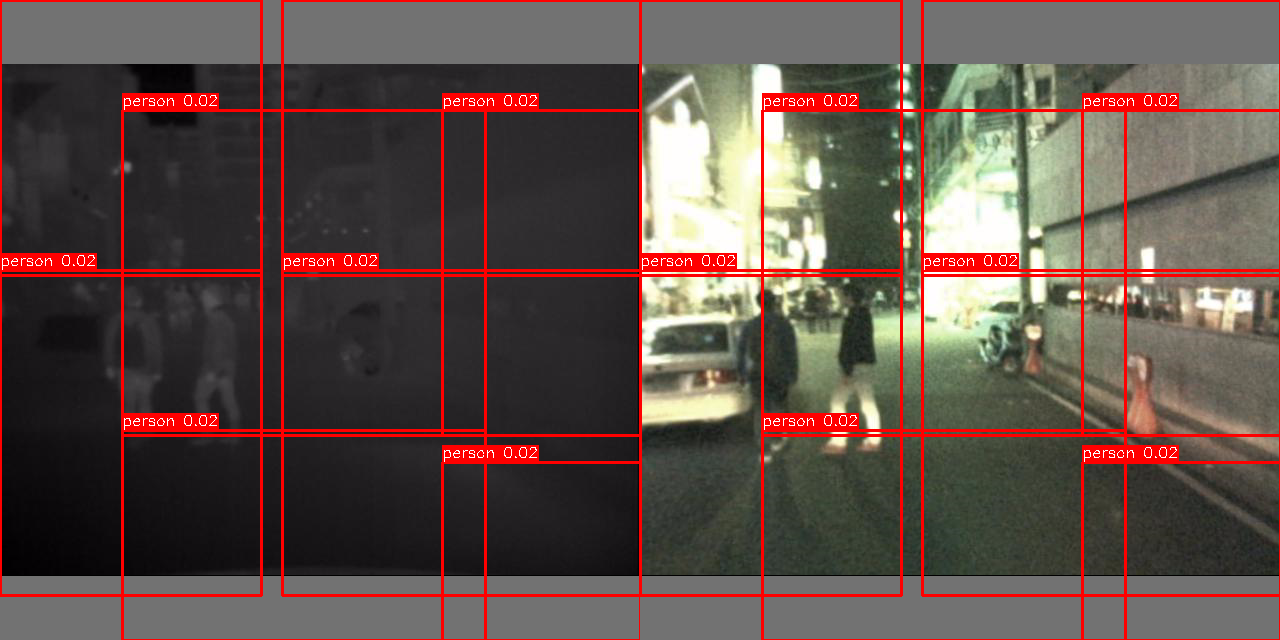

In [56]:
from utils.general import scale_boxes, non_max_suppression
import torch
from models.yolo import Model
from utils.torch_utils import select_device

weights = '/home/lbw/workspace/AUE8088/runs/train/yolo11s_aug_ep50_e05_lrf/weights/best.pt'      # Train your own model!
data = 'data/kaist-rgbt-fold1.yaml'
cfg = 'models/yolo11s_kaist-rgbt_no25.yaml'
hyp = 'data/hyp.rgbt_lrf.yaml'
nc = 1
half = False  # use FP16 half-precision inference
dnn = False  # use OpenCV DNN for ONNX inference
device = select_device('cpu')

with open(hyp, errors="ignore") as f:
    hyp = yaml.safe_load(f)  # load hyps dict

model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)  # create

# inference
model.eval()
ims = [im.to(device, non_blocking=True).float() / 255 for im in imgs]    # For RGB-T input
with torch.no_grad():
    pred = model(ims)  # forward

# conf_thres = 0.25  # confidence threshold
# iou_thres = 0.45  # NMS IOU threshold
conf_thres = 0.02000001  # confidence threshold
iou_thres = 0.1789  # NMS IOU threshold
max_det = 1000  # maximum detections per image
classes = None
agnostic_nms = False  # class-agnostic NMS

pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)

# [TODO] draw predictions (see detect.py:L178)
# 두 번째 TODO: 예측 결과 그리기

# 직접 scale_boxes() 호출하는 부분 제거
# scale_boxes() 함수는 아래의 예측 결과 그리기 과정에서 사용됨

# 예측 결과 그리기 함수 정의
def draw_predictions(imgs, pred, paths, shapes, names=None, conf_thres=0.25):
    """
    예측 결과 + anchor box를 함께 시각화합니다.
    imgs: 입력 이미지 리스트 [lwir, visible]
    pred: 예측 결과 리스트 (non_max_suppression 적용 후)
    paths: 이미지 경로 리스트
    shapes: 원본 이미지 크기 리스트
    names: 클래스 이름 리스트 (dict)
    """
    # 이미지 준비
    img_lwir = imgs[0][0].numpy().transpose((1, 2, 0))
    img_vis = imgs[1][0].numpy().transpose((1, 2, 0))
    h, w = img_lwir.shape[:2]
    
    img_lwir_copy = np.ascontiguousarray(img_lwir.copy())
    img_vis_copy = np.ascontiguousarray(img_vis.copy())

    # 클래스 색상
    colors = {
        0: (255, 0, 0),
        1: (0, 255, 0),
        2: (0, 0, 255),
        3: (255, 0, 255),
    }

    # ───────────────────────────────────────
    # ① detection 결과 그리기
    # ───────────────────────────────────────
    for i, det in enumerate(pred):
        if len(det):
            det[:, :4] = scale_boxes(imgs[0].shape[2:], det[:, :4], shapes[i][0]).round()
            
            for *xyxy, conf, cls in reversed(det):
                xyxy = [int(x) for x in xyxy]
                cls = int(cls)
                color = colors.get(cls, (255, 255, 0))
                label = f'{names[cls] if names else cls} {conf:.2f}'
                
                cv2.rectangle(img_lwir_copy, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), color, 2)
                cv2.rectangle(img_vis_copy,  (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), color, 2)
                
                font = cv2.FONT_HERSHEY_SIMPLEX
                font_scale = 0.5
                (label_width, label_height), baseline = cv2.getTextSize(label, font, font_scale, 1)
                
                cv2.rectangle(img_lwir_copy, (xyxy[0], xyxy[1] - label_height - 5), 
                              (xyxy[0] + label_width, xyxy[1]), color, -1)
                cv2.rectangle(img_vis_copy, (xyxy[0], xyxy[1] - label_height - 5), 
                              (xyxy[0] + label_width, xyxy[1]), color, -1)
                
                cv2.putText(img_lwir_copy, label, (xyxy[0], xyxy[1] - 5), font, font_scale, (255, 255, 255), 1)
                cv2.putText(img_vis_copy,  label, (xyxy[0], xyxy[1] - 5), font, font_scale, (255, 255, 255), 1)

    # ───────────────────────────────────────
    # ② anchor box 시각화 추가
    # ───────────────────────────────────────

    # 결합
    combined_img = np.concatenate([img_lwir_copy, img_vis_copy], axis=1)
    return combined_img

# 클래스 이름 가져오기
names = data_dict["names"] if "names" in data_dict else None

# 예측 결과 그리기 함수 호출
result_image = draw_predictions(imgs, pred, paths, shapes, names)

# PIL 이미지로 변환 후 표시
from PIL import Image
result_pil = Image.fromarray(result_image)
display(result_pil)  # 주피터 노트북에서 이미지 표시

# 또는 matplotlib으로 표시
plt.figure(figsize=(12, 6))
plt.imshow(result_image)
plt.title('KAIST RGB-T Object Detection')
plt.axis('off')
plt.savefig('detection_result.png')  # 결과 저장
plt.show()  # 결과 표시 시도

In [9]:
print(len(pred), "predictions")
pred[0]

1 predictions


tensor([[2.10000e+01, 3.86000e+02, 1.40000e+02, 4.78000e+02, 2.02083e-02, 0.00000e+00],
        [4.05000e+02, 3.86000e+02, 5.24000e+02, 4.78000e+02, 2.02083e-02, 0.00000e+00],
        [3.73000e+02, 3.86000e+02, 4.92000e+02, 4.78000e+02, 2.02083e-02, 0.00000e+00],
        ...,
        [2.13000e+02, 1.62000e+02, 3.32000e+02, 2.54000e+02, 2.02083e-02, 0.00000e+00],
        [1.81000e+02, 1.62000e+02, 3.00000e+02, 2.54000e+02, 2.02083e-02, 0.00000e+00],
        [1.49000e+02, 1.62000e+02, 2.68000e+02, 2.54000e+02, 2.02083e-02, 0.00000e+00]])